# Basic Classification NLP
This is an example of a simple NLP classification using machine learning and a SVC model.

In this example we will use an Amazon review dataset.

First we will need to load the required libraries.

In [1]:
import pandas as pd
#import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
#import xlsxwriter as xlw
import os
import html
import re
#import seaborn as sb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report
#from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.metrics import mean_absolute_error, mean_squared_error
#from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
import json
import gzip
#import math

Next, we'll load our data.

In [2]:
# dataset found here http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz
data = pd.read_json("C:\\Users\\kelvi\\Desktop\\reviews_Musical_Instruments_5.json.gz", lines=True)

# select the relevant categories for text from the data
data = data[['reviewText', 'overall']]

We'll create 2 custom functions below to use on our data

In [3]:
# text cleaning function
def clean(text):
    # convert html escapes to characters
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text in code or brackets
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of whitespaces
    text = re.sub(r'\s+', ' ', text)
    # make lower case
    text = text.lower()
    
    return text.strip()

# make a custom function which says whether a rating is positive or negative
def review_rating(value):
    if value['overall'] > 3: # a rating of 4 stars or more is viewed as "positive"
        return "positive"
    elif value['overall'] < 3:
        return "negative"
    else:
        return "remove me!"

Let's apply these functions to our data and do some filtering

In [4]:
data['reviewText'] = data['reviewText'].apply(clean)

data['type'] = data.apply(review_rating,axis=1)

# we'll remove the 3 star removes as they're not very helpful to say without investigation as to whether it is positive or negative
data = data[data['type']!="remove me!"]

Next, we'll examine the dataset and adjust it if necessary

In [5]:
# let's get a breakdown of our dataset so we know how it is comprised
type_counts = data['type'].value_counts()

# this is quite one-sided, let's remove most of the positive to make the dataset more even
data_pos = data[data['type']=="positive"]
data_neg = data[data['type']=="negative"]

data_pos = data_pos[1:800]

data = pd.concat([data_pos,data_neg],axis=0)

Get the data ready for machine learning

In [6]:
# train-test split
############# set X and y variables for model
y = data['type']
#yvalue='chk_Hot' # for graph
X = data['reviewText']# must be single brackets for tdidf #pd.get_dummies(df)

sample = 0.3 #size of test dataset

#default train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=sample,random_state=42,stratify=y,shuffle=True)


Configure the linearsvc model

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(stop_words="english")
model = SVC(kernel="linear", C=1, probability=True, random_state=42)

In [8]:
# create a data pipeline
training_pipeline = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words="english")), ('model', model)])

How does this model score without any hyperparameter adjustments?

In [9]:
model_score = cross_val_score(training_pipeline, X_train, y_train,cv=3)
model_score.mean()

0.8205260345090853

Can we improve on this score if we adjust any hyperparameter values?

In [10]:
# get a list of what we can alter in the param grid
print(training_pipeline.get_params().keys())

# adjust some of these here
grid_param = {
    'tfidf__min_df': [1,3,5,7],
    'tfidf__ngram_range': [(1,2),(1,3),(1,5),(1,6),(1,9)],
    'model__C': [1,2,3,4,5],
    #'model__loss': ['hinge']
    'model__kernel': ['linear']
    }
        

gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_param,
                                   cv=10)

gridSearchProcessor.fit(X_train,y_train)

best_model_type = gridSearchProcessor.best_params_

best_model_score = gridSearchProcessor.best_score_

best_model = gridSearchProcessor.best_estimator_

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'model', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'model__C', 'model__break_ties', 'model__cache_size', 'model__class_weight', 'model__coef0', 'model__decision_function_shape', 'model__degree', 'model__gamma', 'model__kernel', 'model__max_iter', 'model__probability', 'model__random_state', 'model__shrinking', 'model__tol', 'model__verbose'])


And the score is...

In [11]:
print(best_model_score)

0.8453524004085802


This is a slight improvement on the default model score. We can have a quick look at how the model is generating a positive/negative prediction (the top word scores for positive/ for negative) below:

<Axes: ylabel='feature'>

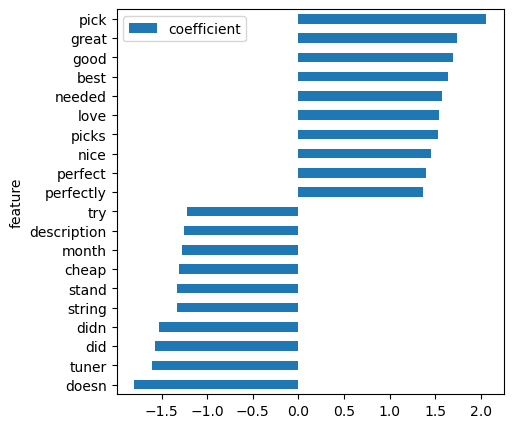

In [12]:
coef = gridSearchProcessor.best_estimator_.steps[1][1].coef_[0].A[0]

vocabulary_positions = coef.argsort()
vocabulary = gridSearchProcessor.best_estimator_.steps[0][1].get_feature_names_out()

top_words = 10
top_positive_coef = vocabulary_positions[-top_words:].tolist()
top_negative_coef = vocabulary_positions[:top_words].tolist()

# make df

core_ui = pd.DataFrame([[vocabulary[c],
                         coef[c]] for c in top_positive_coef + top_negative_coef],
                       columns=["feature","coefficient"]).sort_values("coefficient")

core_ui.set_index("feature").plot.barh(figsize=(5,5))

For the positive scoring words these indicate the words more strongly linked to a "positive" review whilst the negative scoring words are more strongly linked to "negative" reviews. Let's take a look at generating some predictions and see any that are correct/incorrect to see if we can determine why the model may have predicted as it did.

In [13]:
# make a new prediction dataset
Xtest1 = data['reviewText']

# this has already been cleaned otherwise we would apply the clean function again

# generate new predictions using the best model (on the same dataset and we can see how it did)

preds = best_model.predict(Xtest1)
df = pd.DataFrame(data)
df1 = pd.DataFrame(preds)

#df = pd.merge(df,df1,how = 'left',left_index = True, right_index = True)
df1.index=df.index
df = pd.concat([df,df1],axis=1) # slab two columns together 0 means rows
df.rename(columns={0:'type_pred'},inplace=True)

# let's focus on the reviews that were incorrectly predicted and see if we can determine why
df_err = df[df['type']!=df['type_pred']]

In [14]:
# view a sample of negative
df_err_neg = df_err[df_err['type']=="positive"][1:5]
df_err_neg

,reviewText,overall,type,type_pred
19,fender cords look great and work just as well....,5,positive,negative
42,zero issues with this cable so far. it feels f...,5,positive,negative
44,i bought this because i wanted a cheap replace...,5,positive,negative
79,only complaint is the size which is my fault. ...,4,positive,negative


For line 79, "complaint" could be viewed as a negative
For line 44, "cheap" could be viewed positively or negatively

In [15]:
# view a sample of positive
df_err_pos = df_err[df_err['type']=="negative"][1:5]
df_err_pos

,reviewText,overall,type,type_pred
286,the handle and spring strength make this uncom...,2,negative,positive
335,it's good but think its a bit expensive for ju...,2,negative,positive
376,the epiphone les paul guitars don't particular...,2,negative,positive
412,"from greg abrams review, entitled ""for all but...",2,negative,positive


Line 335 features "good", which could mean the review is deemed positive